In [333]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import time
from mypulp import *
from itertools import permutations
from itertools import combinations
import random

%matplotlib inline

# 巡回セールスマン問題

## 例題の作成
- 400点を正規分布に従う乱数で生成
- 5つのクラスターからなる需要点集合を想定する

In [265]:
np.random.seed(0)
order = 5

# クラスター1
x1 = np.random.normal(loc=10, scale=2, size=int(10*order))
y1 = np.random.normal(loc=10, scale=2, size=int(10*order))

# クラスター2
x2 = np.random.normal(loc=-10, scale=3, size=int(10*order))
y2 = np.random.normal(loc=5, scale=1, size=int(10*order))

# クラスター3
x3 = np.random.normal(loc=0, scale=1, size=int(5*order))
y3 = np.random.normal(loc=0, scale=1, size=int(5*order))

# クラスター4
x4 = np.random.normal(loc=6, scale=2, size=int(5*order))
y4 = np.random.normal(loc=-6, scale=2, size=int(5*order))

# クラスター5
x5 = np.random.normal(loc=0, scale=1, size=int(10*order))
y5 = np.random.normal(loc=9, scale=3, size=int(10*order))

In [266]:
x = np.concatenate([x1, x2, x3, x4, x5])
y = np.concatenate([y1, y2, y3, y4, y5])

I = np.stack([x, y], axis=1)

# 距離行列を計算
D = cdist(I, I, metric='euclidean')

需要数 : 200


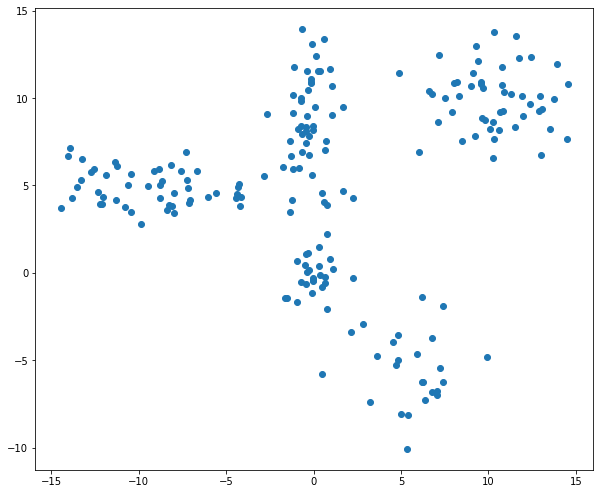

In [268]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(I[:,0], I[:,1])
ax.set_aspect('equal', 'box')
print(f'需要数 : {len(D)}')

## 整数計画問題としての定式化 (厳密解法)

## MTZ

- 部分巡回路が生成されることを防ぐため，どのノードを訪れるのが何番目かを表す変数を導入する
- 簡単に実装できるが数十ノード規模の問題でも相当時間がかかる

\begin{align}
\mathrm{minimize} \quad & \sum_{i \in I} \sum_{j \in I} d_{ij}x_{ij}\\
\mathrm{subject\,to} \quad & \sum_{j \in I,\,i\ne j} x_{ij} = 1\quad \forall i \in I \\
& \sum_{j \in I,\,i\ne j} x_{ji} = 1\quad \forall i \in I \\
& u_{i} - u_{j} + n x_{ij} \le n - 1 \quad \forall i,j \in I,\,i\ne j\\
& u_{0} = 0\\
& 1 \le u_{i} \le n-1 \quad \forall i \in I\\
& x_{ij} \in \{0,1\} \quad \forall i,j \in I\\
& u_{i} \in \mathbb{Z} \quad \forall i \in I
\end{align}

- $n$ は需要点数 ($n = |I|$)
- $d_{ij}$ は需要点 $i$ と需要点 $j$ の距離

In [269]:
# モデルの生成
def TSP_MTZ(D):
    """
    TSPモデル.MTZの定式化を実装
    
    Parameters
    ----------
    D : numpy.ndarray()
        距離行列 (需要点数×需要点数)
    
    Returns
    ----------
    model : mypulp.Model()
        モデルインスタンス
    """
    
    model = Model('TSP')
    x, u = {},{}
    
    demand_num = len(D)
    
    # 変数定義
    for i in range(demand_num):
        if i == 0:
            u[i] = model.addVar(vtype = 'I', lb = 0, ub = demand_num - 1, name=f'u_{i}')
        else:
            u[i] = model.addVar(vtype = 'I', lb = 1, ub = demand_num - 1, name=f'u_{i}')
        for j in range(demand_num):
            x[i, j] = model.addVar(vtype = 'B', name=f'x_{i}_{j}')
    
    model.update()
    
    # 制約式
    # 流量保存
    for i in range(demand_num):
        iterator = [ j for j in range(demand_num) if i != j]
        model.addConstr(quicksum(x[i, j] for j in iterator) == 1)
        model.addConstr(quicksum(x[j, i] for j in iterator) == 1)
    
    # 部分巡回路除去制約(MTZ)
    for i, j in permutations(list(range(1, demand_num)), 2):
        model.addConstr(u[i] - u[j] + demand_num*x[i,j] <= demand_num - 1)
        
    # 開始地点をノード0に指定
    model.addConstr(u[0] == 0)
    
    model.update()
    
    # 目的関数を設定
    model.setObjective(quicksum( quicksum( D[i][j]*x[i, j] for j in range(demand_num)) for i in range(demand_num)), GRB.MINIMIZE)
    
    model.update()
    model.__data = x, u
    
    return model

## Lazy Constraint

- 部分巡回路が最適解で発生した場合，その部分巡回路が発生しないようにする制約を加えて，繰り返し最適化を行う方法
- 平面切除法

\begin{align}
\mathrm{minimize} \quad & \sum_{i \in I} \sum_{j \in I} d_{ij}x_{ij}\\
\mathrm{subject\,to} \quad & \sum_{j \in I,\,i\ne j} x_{ij} = 1\quad \forall i \in I \\
& \sum_{j \in I,\,i\ne j} x_{ji} = 1\quad \forall i \in I \\
& \sum_{i \in p} \sum_{j \in \{k | k \in I, k \notin p \} } x_{ij} \ge 1 \quad \forall p \in ST\\
& \sum_{i \in p} \sum_{j \in \{k | k \in I, k \notin p \} } x_{ji} \ge 1 \quad \forall p \in ST\\
& x_{ij} \in \{0,1\} \quad \forall i,j \in I\\
\end{align}

- $ST$ はこれまでの最適化の結果に現れた部分巡回路の集合
- $ST = \{ [0,3,4,0], [6,7,8,9,1,6], \dots \}$ のように巡回路を各要素として持つ

In [270]:
# モデルの生成
def TSP_Lazy(D, st_list):
    """
    TSPモデル.MTZの定式化を実装
    
    Parameters
    ----------
    D : numpy.ndarray()
        距離行列 (需要点数×需要点数)
    st_list : list of list
        部分巡回路のリスト
    
    Returns
    ----------
    model : mypulp.Model()
        モデルインスタンス
    """
    
    model = Model('TSP')
    x = {}
    
    demand_num = len(D)
    
    # 変数定義
    for i in range(demand_num):
        for j in range(demand_num):
            x[i, j] = model.addVar(vtype = 'B', name=f'x_{i}_{j}')
    
    model.update()
    
    # 制約式
    # 流量保存
    for i in range(demand_num):
        iterator = [ j for j in range(demand_num) if i != j]
        model.addConstr(quicksum(x[i, j] for j in iterator) == 1)
        model.addConstr(quicksum(x[j, i] for j in iterator) == 1)
    
    # 部分巡回路除去制約(Lazy)
    # 2頂点間の往復を禁止 (部分巡回路ができる前に予め防いでおく)
    for i in range(demand_num):
        for j in range(i+1, demand_num):
            model.addConstr(x[i, j] + x[j, i] <= 1)
    
    for path in st_list:
        
        # 部分巡回路pathに含まれないノード集合
        nots = [ j for j in range(demand_num) if j not in path ]
        
        # 部分巡回路のいずれかのノードから巡回路以外のノードへ出るという制約
        model.addConstr(quicksum( quicksum(x[i, j] for i in path[:-1]) for j in nots ) >= 1)
        
        # 部分巡回路のいずれかのノードに巡回路以外のノードから入るという制約
        model.addConstr(quicksum( quicksum(x[j, i] for i in path[:-1]) for j in nots ) >= 1)
    
    model.update()
    
    # 目的関数を設定
    model.setObjective(quicksum( quicksum( D[i][j]*x[i, j] for j in range(demand_num)) for i in range(demand_num)), GRB.MINIMIZE)
    
    model.update()
    model.__data = x
    
    return model

In [271]:
st_num = len(D)

# 部分巡回路のリスト
st_path = []

# 部分巡回路が1個になるまで
while st_num > 1:
    
    # TSP (の緩和問題)を求解
    model_L = TSP_Lazy(D, st_path)
    model_L.optimize()
    
    # 解を格納
    path_list = []
    path_dict = {}
    for v in model_L.getVars():
        if(v.X > 0):
            s = v.VarName
            if('x' in s):
                index1 = s.find('_')
                index2 = s.find('_', index1+1)
                path_list.append([int(s[index1+1:index2]), int(s[index2+1:])])
                path_dict[int(s[index1+1:index2])] = int(s[index2+1:])
    
    
    # 現在の最適解における部分巡回路を調べる
    # 現在の解に存在する巡回路
    now_st_path = []
    # すでに調べた巡回路に含まれているノード数
    node_num = 0
    # ノードのset
    node_set = set(range(len(D)))

    # すべてのノードが巡回路中に現れるまで
    while node_num < len(D):
        
        # 巡回路をたどり始める最初のノード
        st = node_set.pop()
        # 巡回路
        tour = []
        flag = True

        while flag:

            tour.append(st)
            # node_setから，すでに巡回路に登場したノードを除く
            node_set -= {st}
            # 次のノードをたどる
            st = path_dict[st]
            
            # もし一周して戻ってきていたら
            if st in tour:
                flag = False
        
        # 巡回路に登場したノード数を記録
        node_num += len(tour)
        # 一周させるため最初のノードを最後にも加える
        tour.append(tour[0])
        
        # 現在の解における巡回路リストに追加
        now_st_path.append(tour)
        # 累積巡回路リストに追加
        st_path.append(tour)
    
    # 現在の解における巡回路の数を集計
    st_num = len(now_st_path)
    print(f'巡回路個数 : {st_num}')

巡回路個数 : 27
巡回路個数 : 15
巡回路個数 : 19
巡回路個数 : 11
巡回路個数 : 8
巡回路個数 : 7
巡回路個数 : 6
巡回路個数 : 5
巡回路個数 : 5
巡回路個数 : 2
巡回路個数 : 1


目的関数値 : 186.51954967237185


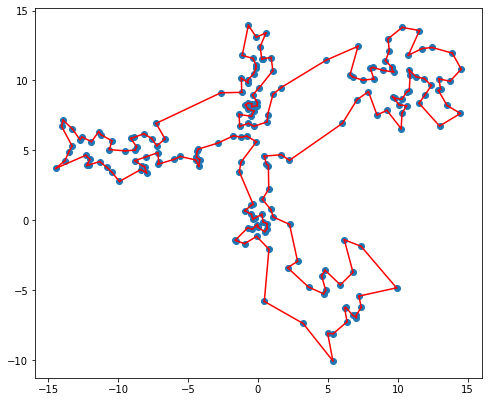

In [276]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(I[:,0], I[:,1])

for path in path_list:
    ax.plot([ I[path[0], 0], I[path[1], 0] ],[ I[path[0], 1], I[path[1], 1] ], c='r')
    
ax.set_aspect('equal', 'box')

print(f'目的関数値 : {model_L.ObjVal}')

## メタヒューリスティック手法

### 単純局所探索 (Local Search)

- Local Searchを実装するには， 次の2つが必要
    1. 近傍の定義
    2. 移動戦略 (move strgategy) の決定
- 今回は近傍を2-opt近傍，移動戦略は即時移動戦略 (FA) とする
- 2-opt近傍は，暫定解の巡回路において，2本のエッジを入れ替えて得られる巡回路のこと
- 即時移動戦略とは，近傍をランダムな順番で調べていき，改善する解が見つかり次第，暫定解を移動する方法のこと

2-opt近傍の実装方法
- 暫定解の経路が $[0, 1, 2, 3, 4, 5]$ であるとき， $1 \rightarrow 2$ と $4 \rightarrow 5$ を入れ替えた経路は， $[0,1,4,3,2,5]$ となる
- $[0,1,2,3,4,5]$ のうち，$[2,3,4]$ の順番を反転することで得られる
- 隣合うエッジ同士の入れ替えは意味を成さないので， ノード数が $n$ のときの2-opt近傍の数は $_{n}C_{2} - n$ 個となる

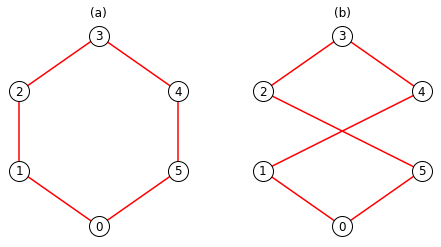

In [474]:
# 暫定解の経路
path1 = [0,1,2,3,4,5]

# 1->2 と 4->5 を入れ替えた経路 (2-opt近傍の1つ)
path2 = [0,1,4,3,2,5]

fig, ax = plt.subplots(1,2,figsize=(8,4))
x_list = [0, -1, -1, 0 , 1, 1]
y_list = [0.3, 1, 2, 2.7, 2, 1]

# ノードを描画
ax[0].scatter(x_list, y_list, c='w', edgecolors='k', s=400, zorder=2)
ax[1].scatter(x_list, y_list, c='w', edgecolors='k', s=400, zorder=2)

for i, xpos, ypos in zip([0,1,2,3,4,5], x_list, y_list):
    ax[0].text(xpos, ypos, str(i), ha='center', va='center', fontsize=12, zorder=3)
    ax[1].text(xpos, ypos, str(i), ha='center', va='center', fontsize=12, zorder=3)

# 経路を描画
for i, j in zip(path1, path1[1:]+path1[0:1]):
    ax[0].plot([x_list[i], x_list[j]], [y_list[i], y_list[j]], c='r', zorder=1)
    
for i, j in zip(path2, path2[1:]+path2[0:1]):
    ax[1].plot([x_list[i], x_list[j]], [y_list[i], y_list[j]], c='r', zorder=1)

#ax[1].plot([x_list[1], x_list[2]], [y_list[1], y_list[2]], c='r', linestyle='dashed', linewidth = 1, zorder=1)
#ax[1].plot([x_list[4], x_list[5]], [y_list[4], y_list[5]], c='r', linestyle='dashed', linewidth = 1, zorder=1)
    
ax[0].set_title('(a)')
ax[1].set_title('(b)')    
ax[0].set_aspect('equal','box')
ax[0].set_axis_off()
ax[1].set_aspect('equal','box')
ax[1].set_axis_off()

In [410]:
def neighbor_tour(seed_tour, a, b):
    """
    2-optの近傍解を返す関数
    暫定解の巡回路において， a番目とa+1番目に訪問するノード間の枝と，b番目とb+1番目に訪問するノード間の枝を入れ替えた巡回路を出力する
    
    Parameters
    ----------
    seed_tour : list
        暫定解の巡回路における訪問順にノード番号が格納されたリスト
    a : int
        入れ替える1つ目の枝の訪問順
    b : int
        入れ替える2つ目の枝の訪問順
        
    Returns
    ----------
    replace_tour : list
        枝を入れ替えた巡回路のリスト
    """
    
    min_id = min(a,b)
    max_id = max(a,b)
    
    replace_tour = seed_tour[0 : min_id+1] + seed_tour[max_id : min_id : -1] + seed_tour[max_id+1:]
    
    return replace_tour

In [347]:
def culc_objval(tour, D):
    """
    巡回路の総距離を計算する関数
    
    Parameters
    ----------
    tour : list
        巡回路
    D : numpy.ndarray()
        距離行列
    
    Returns
    ----------
    obj_val : float
        総距離
    """
    
    obj_val = 0
    
    for i, j in zip(tour, tour[1:]+tour[0:1]):
        obj_val += D[i][j]
    
    return obj_val

In [467]:
def local_search(ini_sol, D):
    """
    ini_solを初期解として，単純局所探索を行う関数
    
    Parameters
    ----------
    ini_sol : list
        初期解の巡回路
    D : numpy.ndarray()
        距離行列
    
    Returns
    ----------
    opt_tour : list
        単純局所解の巡回路
    opt_val : float
        単純局所解の目的関数値
    """
    continue_flag = True
    demand_num = len(ini_sol)
    opt_val = culc_objval(ini_sol, D)
    opt_tour = ini_sol
    
    replace_edges = list(combination(list(range(demand_num)), 2))
    
    while continue_flag:
        
        continue_flag = False
        random.shuffle(replace_edges)
        
        for edge in replace_edges:
            
            # 近傍を生成
            a, b = edge
            temp_tour = neighbor_tour(opt_tour, a, b)
            temp_val = culc_objval(temp_tour, D)
            
            if temp_val < opt_val:
                opt_tour = temp_tour
                opt_val = temp_val
                continue_flag = True
                break
    
    return opt_tour, opt_val

In [489]:
def local_search_with_drawing(ini_sol, D, I):
    """
    ini_solを初期解として，単純局所探索を行う関数 (暫定解の描画も行う)
    
    Parameters
    ----------
    ini_sol : list
        初期解の巡回路
    D : numpy.ndarray()
        距離行列
    
    Returns
    ----------
    opt_tour : list
        単純局所解の巡回路
    opt_val : float
        単純局所解の目的関数値
    """
    
    continue_flag = True
    demand_num = len(ini_sol)
    opt_val = culc_objval(ini_sol, D)
    opt_tour = ini_sol
    
    replace_edges = list(combination(list(range(demand_num)), 2))
    
    loop_num = 0
    
    plot_list = [[0, opt_tour, opt_val]]
    
    while continue_flag:
        
        continue_flag = False
        random.shuffle(replace_edges)
        
        for edge in replace_edges:
            
            # 近傍を生成
            a, b = edge
            temp_tour = neighbor_tour(opt_tour, a, b)
            temp_val = culc_objval(temp_tour, D)
            
            if temp_val < opt_val:
                opt_tour = temp_tour
                opt_val = temp_val
                continue_flag = True
                loop_num += 1
                
                if (loop_num%100 == 0): 
                    plot_list.append([loop_num,  opt_tour, opt_val])
                
                break
    
    plot_list.append([loop_num,  opt_tour, opt_val])
    
    # 解の改善を描画
    plot_num = len(plot_list)
    # 縦に並べる図の数
    v_num = (plot_num - 1)//3 + 1
    fig, ax = plt.subplots(v_num, 3, figsize=(3*5,v_num*5))
    
    for plot_id, plots in enumerate(plot_list):
        ax[plot_id//3, plot_id%3].scatter(I[:, 0], I[:, 1], c='b',  s=20, zorder=2)
        
        for i, j in zip(plots[1], plots[1][1:]+plots[1][0:1]):
            ax[plot_id//3, plot_id%3].plot([I[i, 0], I[j, 0]], [I[i, 1], I[j, 1]], c='r', zorder=1,  linewidth=0.5)
        
        ax[plot_id//3, plot_id%3].set_aspect('equal', 'box')
        ax[plot_id//3, plot_id%3].set_title(f'loop : {loop_num}, obj_val : {round(plots[2],2)}')

    print(f'暫定解の更新回数 : {loop_num}回')
    print(f'局所最適解の目的関数値 : {round(opt_val, 2)}')
    
    return opt_tour, opt_val

In [490]:
# ランダムに初期解を生成
temp_list = list(range(1, len(D)))
random.shuffle(temp_list)
ini_sol = [0] + temp_list

暫定解の更新回数 : 844回
局所最適解の目的関数値 : 200.92


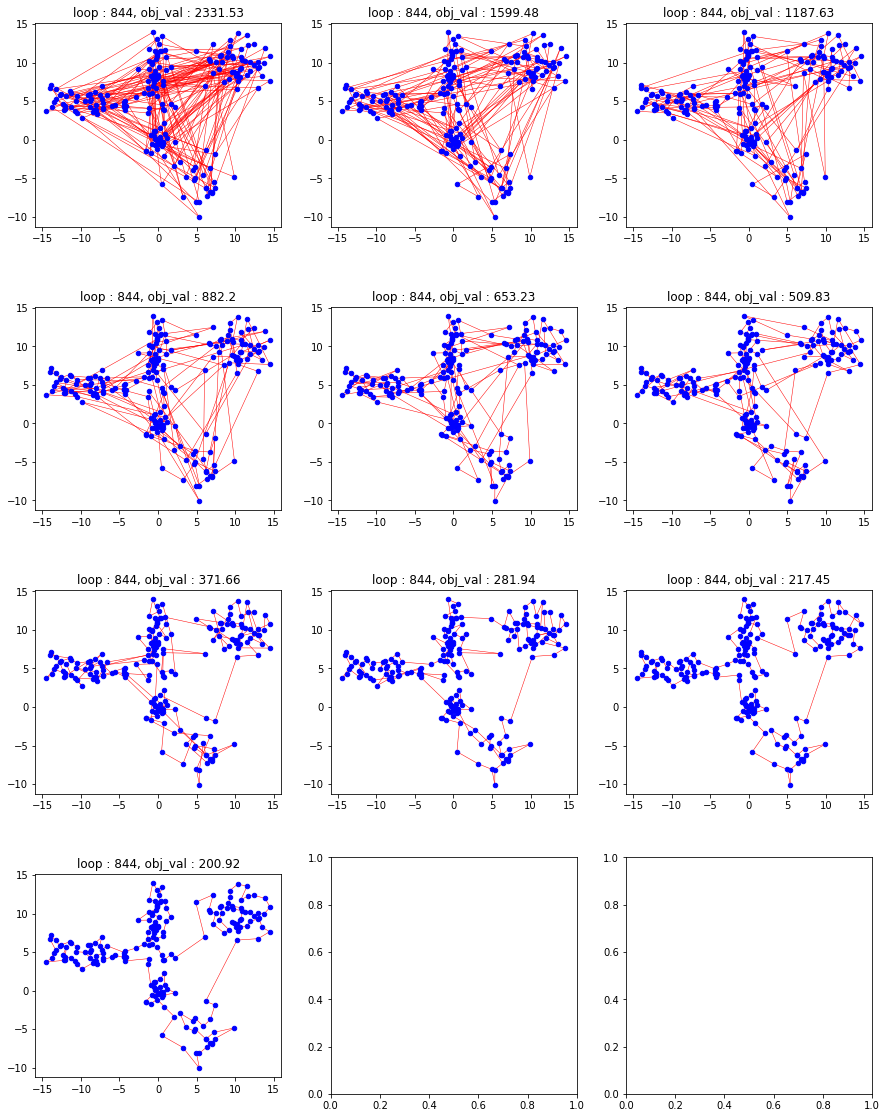

In [491]:
# 局所探索を実行
opt_tour, opt_val = local_search_with_drawing(ini_sol, D, I)

In [471]:
opt_tour, opt_val = local_search(ini_sol, D)

In [472]:
opt_val

211.02834522164576

### double-bridge近傍

In [495]:
def double_bridge(seed_tour, change_list):
    """
    double-bridge近傍を返す関数
    
    Parameters
    ----------
    seed_tour : list
        暫定解
    change_list : list
        入れ替える枝を指定する関数
    
    Retunrs
    ----------
    neighbor_tour : list
        近傍の巡回路
    """
    
    # 昇順に並べ替え
    change_list.sort()
    a = change_list[0]
    b = change_list[1]
    c = change_list[2]
    d = change_list[3]
    
    neighbor_tour = seed_tour[0:a+1] + seed_tour[c+1:d+1] + seed_tour[b+1:c+1] + seed_tour[a+1:b+1] + seed_tour[d+1:]
    
    return neighbor_tour